In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from decouple import config
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from keras import Sequential
from keras.layers import Input, Dense, Dropout



In [2]:
csv_path = config("CSV_PATH")

In [3]:
df = pd.read_csv(csv_path)

In [4]:
df.head()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t191,t192,t193,t194,t195,t196,t197,t198,t199,Classes
0,24.00,24.00,23.00,25.00,24.00,25.00,24.00,24.00,22.00,25.00,...,1.00,-1.00,1.00,-1.00,1.00,0.00,1.00,0.00,0.00,1
1,23.00,23.00,22.00,21.00,21.00,22.00,23.00,23.00,22.00,21.00,...,-1.00,1.00,0.00,1.00,-1.00,0.00,-1.00,1.00,0.00,1
2,-0.55,-0.55,-0.55,3.45,13.45,11.45,18.45,18.45,20.45,20.45,...,-0.55,0.45,-0.55,0.45,-0.55,0.45,-0.55,0.45,-0.55,1
3,12.30,10.30,15.30,15.30,16.30,15.30,17.30,16.30,17.30,15.30,...,-0.70,0.30,-0.70,0.30,-0.70,1.30,-0.70,1.30,-0.70,1
4,24.85,2.85,5.85,-1.15,2.85,-1.15,1.85,-1.15,0.85,-1.15,...,-0.15,0.85,-1.15,-0.15,-1.15,0.85,-0.15,0.85,-0.15,2


In [5]:
features = df.drop("Classes", axis= 1)
target = df["Classes"]

In [6]:
target_dummies = pd.get_dummies(target)

In [7]:
scaler = StandardScaler()

In [8]:
df_scaled = scaler.fit_transform(features)

### PCA

In [9]:
pca = PCA()
pca.fit(df_scaled)

PCA()

In [10]:
pca.n_components_

100

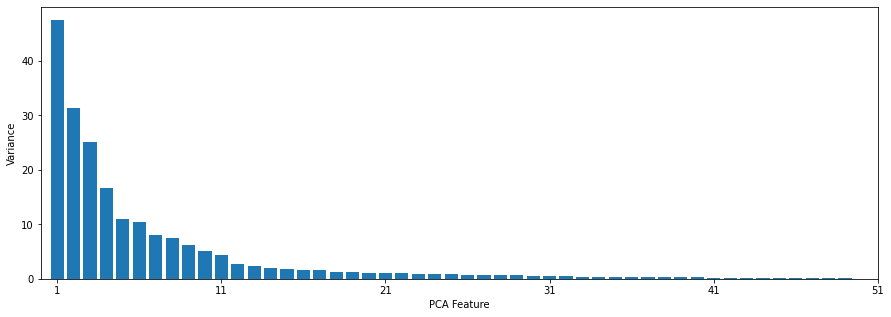

In [11]:
plt.figure(figsize=(15,5))
plt.bar(np.arange(1, 101), pca.explained_variance_)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.xticks(range(1, 101, 10))
plt.xlim(0,51)
plt.show()

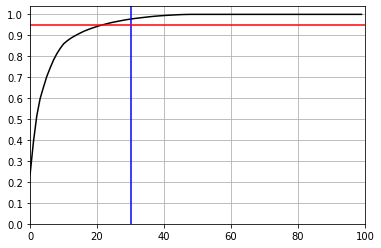

In [12]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='black')
plt.xlim(0,100)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(30, c='b')
plt.axhline(0.95, c='r')
plt.grid()
plt.show()

In [13]:
pca = PCA(n_components=15)
df_pca = pca.fit_transform(df_scaled)

### Neural Network without PCA

In [15]:
x_train, x_test, y_train, y_test = train_test_split(df_scaled, target_dummies,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=target_dummies)

In [16]:
n_features = x_train.shape[1]

In [17]:
n_features

200

In [112]:
model = Sequential()
#model.add(Input(shape=(n_features,)))
model.add(Dense(128, activation="tanh", input_shape=(n_features,)))
model.add(Dense(64, activation="tanh"))
model.add(Dense(7, activation="softmax"))

In [113]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [114]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 128)               2048      
                                                                 
 dense_45 (Dense)            (None, 64)                8256      
                                                                 
 dense_46 (Dense)            (None, 7)                 455       
                                                                 
Total params: 10,759
Trainable params: 10,759
Non-trainable params: 0
_________________________________________________________________


In [115]:
hist = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
3/3 [==============================] - 0s 65ms/step - loss: 2.1255 - accuracy: 0.1000 - val_loss: 1.6914 - val_accuracy: 0.3667
Epoch 2/50
3/3 [==============================] - 0s 11ms/step - loss: 1.7324 - accuracy: 0.3000 - val_loss: 1.4885 - val_accuracy: 0.5333
Epoch 3/50
3/3 [==============================] - 0s 11ms/step - loss: 1.4877 - accuracy: 0.4571 - val_loss: 1.3228 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 11ms/step - loss: 1.2969 - accuracy: 0.5286 - val_loss: 1.1936 - val_accuracy: 0.7000
Epoch 5/50
3/3 [==============================] - 0s 13ms/step - loss: 1.1675 - accuracy: 0.5714 - val_loss: 1.1008 - val_accuracy: 0.7000
Epoch 6/50
3/3 [==============================] - 0s 11ms/step - loss: 1.0683 - accuracy: 0.6857 - val_loss: 1.0266 - val_accuracy: 0.7667
Epoch 7/50
3/3 [==============================] - 0s 11ms/step - loss: 0.9924 - accuracy: 0.7000 - val_loss: 0.9732 - val_accuracy: 0.7667
Epoch 8/50
3/3 [===========

In [116]:
loss, acc = model.evaluate(x_train, y_train, verbose=0)
print("Train loss:", loss)
print("Train acc:", acc)

Train loss: 0.1602318286895752
Train acc: 0.9714285731315613


In [117]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", loss)
print("Test acc:", acc)

Test loss: 0.2676853835582733
Test acc: 0.9333333373069763


In [118]:
model.save("final_model_all_features.h5")

### Neural Network with PCA

In [36]:
x_train, x_test, y_train, y_test = train_test_split(df_pca, target_dummies,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=target_dummies)

In [37]:
n_features = x_train.shape[1]

In [38]:
n_features

15

In [69]:
model = Sequential()
#model.add(Input(shape=(n_features,)))
#model.add(Dropout(0.30))
model.add(Dense(n_features, activation="tanh", input_shape=(n_features,)))
#model.add(Dense(10, activation="tanh"))
model.add(Dense(7, activation="softmax"))

In [70]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [71]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 15)                240       
                                                                 
 dense_23 (Dense)            (None, 7)                 112       
                                                                 
Total params: 352
Trainable params: 352
Non-trainable params: 0
_________________________________________________________________


In [72]:
hist = model.fit(x_train, y_train, epochs=300, validation_data=(x_test, y_test))

Epoch 1/300
3/3 [==============================] - 0s 64ms/step - loss: 2.5687 - accuracy: 0.1000 - val_loss: 2.3747 - val_accuracy: 0.1000
Epoch 2/300
3/3 [==============================] - 0s 10ms/step - loss: 2.5233 - accuracy: 0.1000 - val_loss: 2.3413 - val_accuracy: 0.1000
Epoch 3/300
3/3 [==============================] - 0s 12ms/step - loss: 2.4836 - accuracy: 0.1000 - val_loss: 2.3089 - val_accuracy: 0.1333
Epoch 4/300
3/3 [==============================] - 0s 11ms/step - loss: 2.4476 - accuracy: 0.1143 - val_loss: 2.2782 - val_accuracy: 0.1333
Epoch 5/300
3/3 [==============================] - 0s 12ms/step - loss: 2.4101 - accuracy: 0.1143 - val_loss: 2.2498 - val_accuracy: 0.1333
Epoch 6/300
3/3 [==============================] - 0s 11ms/step - loss: 2.3770 - accuracy: 0.1143 - val_loss: 2.2221 - val_accuracy: 0.1333
Epoch 7/300
3/3 [==============================] - 0s 11ms/step - loss: 2.3427 - accuracy: 0.1143 - val_loss: 2.1947 - val_accuracy: 0.1333
Epoch 8/300
3/3 [===

In [73]:
loss, acc = model.evaluate(x_train, y_train, verbose=0)
print("Train loss:", loss)
print("Train acc:", acc)

Train loss: 0.33646926283836365
Train acc: 0.9428571462631226


In [74]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", loss)
print("Test acc:", acc)

Test loss: 0.48965418338775635
Test acc: 0.9333333373069763


In [75]:
model.save("final_model_pca.h5")